# import file


c:\Users\Jim\anaconda3\Lib\site-packages\sklearn\utils\_param_validation.py:14: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.0)
  from scipy.sparse import csr_matrix, issparse
D:\Temp\ipykernel_25244\1139185044.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
D:\Temp\ipykernel_25244\1139185044.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
D:\Temp\ipykernel_25244\1139185044.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x

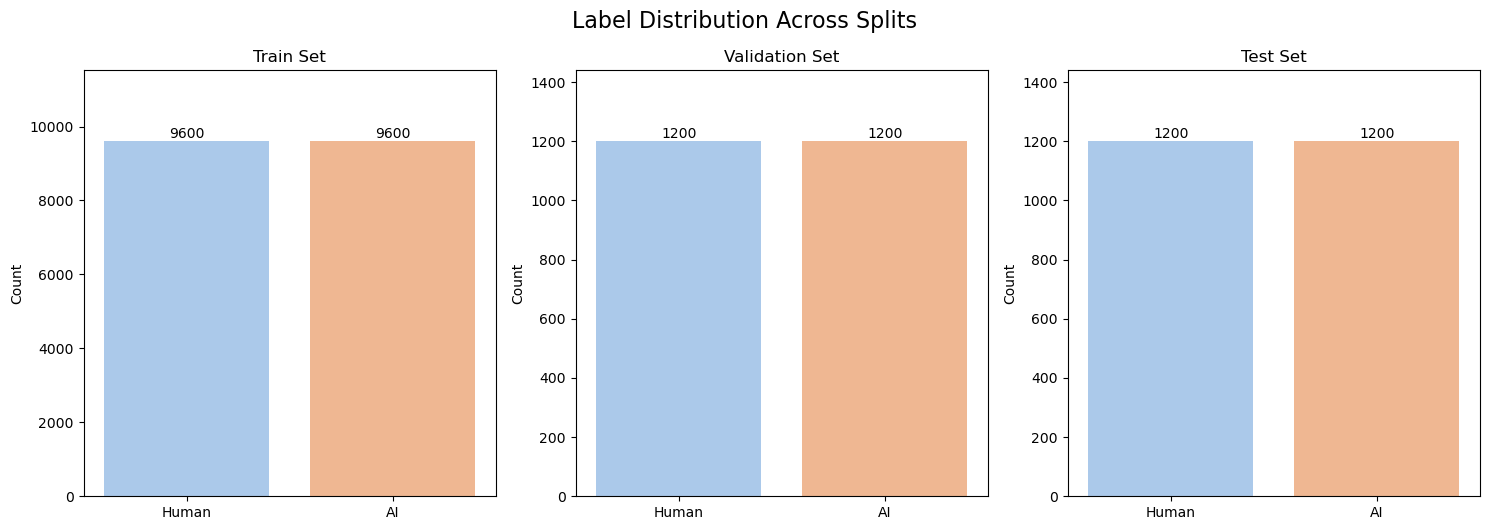

In [1]:
from transformers.utils import logging
logging.set_verbosity_error()

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load dataset
df = pd.read_csv("../final_dataset_fixed.csv")

# Encode labels: human=0, ai=1
df['label'] = df['label'].map({'human': 0, 'ai': 1})

# Split into train, validation, test
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(),
    test_size=0.2, stratify=df['label'], random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels,
    test_size=0.5, stratify=temp_labels, random_state=42
)

# --- Plot class distributions ---
splits = {
    "Train": train_labels,
    "Validation": val_labels,
    "Test": test_labels,
}

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (split_name, split_labels) in enumerate(splits.items()):
    counts = pd.Series(split_labels).value_counts().sort_index()
    class_names = ['Human', 'AI']
    sns.barplot(x=class_names, y=counts.values, ax=axs[i], palette="pastel")
    axs[i].set_title(f"{split_name} Set")
    axs[i].set_ylabel("Count")
    axs[i].set_ylim(0, max(counts.values) * 1.2)
    for j, count in enumerate(counts.values):
        axs[i].text(j, count + 2, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.suptitle("Label Distribution Across Splits", fontsize=16, y=1.05)
plt.show()


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

model_name = "sagorsarker/bangla-bert-base"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# Tokenize datasets (not tensors yet!)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

class BengaliDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            key: torch.tensor(val[idx]) for key, val in self.encodings.items()
        } | {'labels': torch.tensor(self.labels[idx])}

train_dataset = BengaliDataset(train_encodings, train_labels)
val_dataset = BengaliDataset(val_encodings, val_labels)
test_dataset = BengaliDataset(test_encodings, test_labels)


## Training

In [3]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt

# --- Metrics function ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",   # ✅ correct spelling
    save_strategy="epoch",
    logging_strategy="steps",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    weight_decay=0.01,
    report_to="none",
    seed=42,
    disable_tqdm=False,             # ✅ ensure progress bar is enabled
)



# --- Trainer ---
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# --- Train ---
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.037900,0.008635,0.998750,0.998335,0.999167,0.998751
2,0.007400,0.015488,0.997917,0.995851,1.000000,0.997921
3,0.000000,0.006748,0.999167,0.999167,0.999167,0.999167


TrainOutput(global_step=3600, training_loss=0.0218844807223488, metrics={'train_runtime': 1094.1556, 'train_samples_per_second': 52.643, 'train_steps_per_second': 3.29, 'total_flos': 7577598394368000.0, 'train_loss': 0.0218844807223488, 'epoch': 3.0})

# Plots: Training/Validation Loss & Accuracy

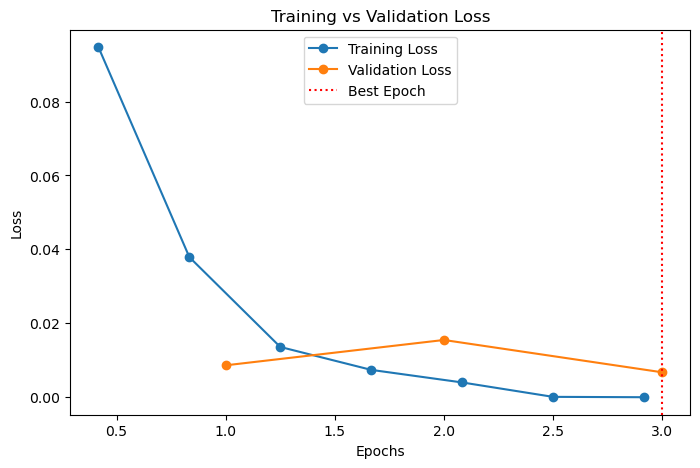

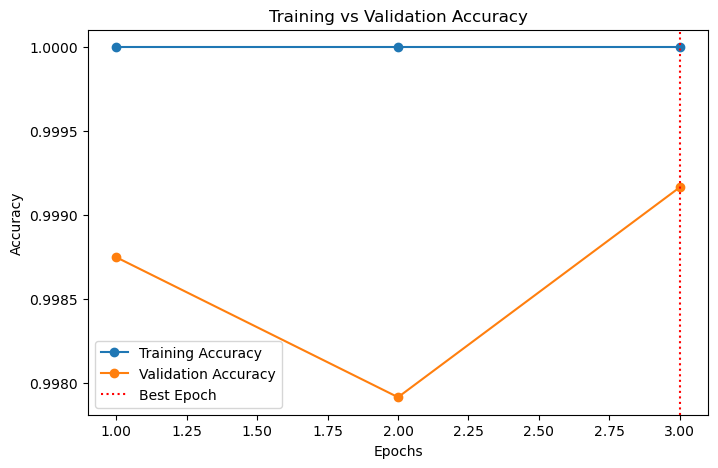

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import pandas as pd

# --- Extract logs efficiently ---
logs = trainer.state.log_history

train_loss, val_loss, val_acc = [], [], []
train_epochs, val_epochs = [], []

for log in logs:
    if "loss" in log and "eval_loss" not in log:
        train_loss.append(log["loss"])
        train_epochs.append(log["epoch"])
    if "eval_loss" in log:
        val_loss.append(log["eval_loss"])
        val_acc.append(log["eval_accuracy"])
        val_epochs.append(log["epoch"])

# --- Smooth training loss per epoch ---
train_df = pd.DataFrame({"epoch": train_epochs, "loss": train_loss})
train_loss_mean = train_df.groupby("epoch")["loss"].mean().tolist()
train_epochs_unique = sorted(train_df["epoch"].unique().tolist())

# --- Compute training accuracy per epoch ---
train_acc = []
for _ in val_epochs:  # one per epoch
    preds_output = trainer.predict(train_dataset)
    preds = np.argmax(preds_output.predictions, axis=-1)
    acc = accuracy_score(preds_output.label_ids, preds)
    train_acc.append(acc)

# --- Plot Loss ---
plt.figure(figsize=(8, 5))
plt.plot(train_epochs_unique, train_loss_mean, label="Training Loss", marker="o")
plt.plot(val_epochs, val_loss, label="Validation Loss", marker="o")
best_epoch = val_epochs[np.argmin(val_loss)]
plt.axvline(best_epoch, color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.savefig("training_validation_loss.png")
plt.show()

# --- Plot Accuracy ---
plt.figure(figsize=(8, 5))
plt.plot(val_epochs, train_acc, label="Training Accuracy", marker="o")
plt.plot(val_epochs, val_acc, label="Validation Accuracy", marker="o")
best_epoch_acc = val_epochs[np.argmax(val_acc)]
plt.axvline(best_epoch_acc, color="red", linestyle="dotted", label="Best Epoch")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.savefig("training_validation_accuracy.png")
plt.show()


# Confusion Matrix on Test Set

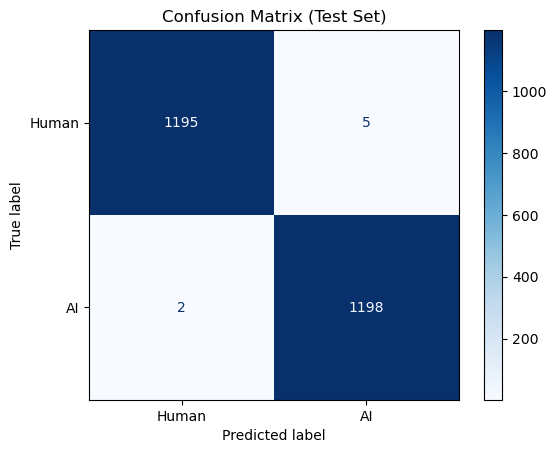

Classification Report (Test Set):

              precision    recall  f1-score   support

       Human     0.9983    0.9958    0.9971      1200
          AI     0.9958    0.9983    0.9971      1200

    accuracy                         0.9971      2400
   macro avg     0.9971    0.9971    0.9971      2400
weighted avg     0.9971    0.9971    0.9971      2400



In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# --- Make predictions on test set ---
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=-1)

# --- Confusion Matrix ---
cm = confusion_matrix(test_labels, preds, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Human","AI"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.savefig("confusion matrix.png")
plt.show()

# --- Classification Report ---
report = classification_report(test_labels, preds, target_names=["Human", "AI"], digits=4)
print("Classification Report (Test Set):\n")
print(report)


In [9]:
# Save the final model and tokenizer
trainer.save_model("./banglabert_model")  # Saves model + config
tokenizer.save_pretrained("./banglabert_tokenizer")  # Saves tokenizer files


('./banglabert_tokenizer\\tokenizer_config.json',
 './banglabert_tokenizer\\special_tokens_map.json',
 './banglabert_tokenizer\\vocab.txt',
 './banglabert_tokenizer\\added_tokens.json',
 './banglabert_tokenizer\\tokenizer.json')

# About Model

In [10]:
# --- Model info ---
from transformers import AutoConfig

# Print model architecture
print("\nModel architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")

# Print model configuration
config = AutoConfig.from_pretrained("sagorsarker/bangla-bert-base")
print("\nModel configuration:")
print(config)



Model architecture:
BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): La

In [11]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# Paths where you saved the model + tokenizer
model_path = "./banglabert_model"
tokenizer_path = "./banglabert_tokenizer"

# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)
model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    id2label={0: "Human", 1: "AI"},
    label2id={"Human": 0, "AI": 1}
)

# Create pipeline for inference
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer)

# --- Test a random text ---
test_text = "এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।"
result = classifier(test_text)

print("Input:", test_text)
print("Prediction:", result)


Input: এই লেখাটি কৃত্রিম বুদ্ধিমত্তা দ্বারা লেখা হয়েছে।
Prediction: [{'label': 'Human', 'score': 0.999997615814209}]
